# COGS 118A - Final Project

# San Diego 2023 Summer Airbnb Daily Price Prediction 

## Group members

- Cassidy Lu
- Guanyu Zhu
- Tze Howe Yap
- David Chen

# Abstract 

Airbnb is a well known internet marketplace for short-term home and apartment rentals. Hosts often face difficulty in determining an optimal price for their listings. Both overpricing and underpricing can lead to revenue loss. To solve this problem, we use previews listed Airbnb in San Diego including their price and descriptions to encode those into machine learning models. 
 We aim to develop a model that can successfully predict Airbnb prices in San Diego based on relevant property features. We measure the model’s accuracy using R^2 and calculate the loss using RMSE. 

# Background

On May 5, 2023, the CDC announced the End of the Federal COVID-19 Public Health Emergency (PHE) Declaration, signaling an official end to this unprecedented pandemic. What's to come is the recovery of the global travel market. Across the entire world, there are currently over 4 million+ Airbnb hosts worldwide and 6 million+ active listings on the platform. In addition to the staggering number of hosts, there are more than 150 million users, and the overall number of bookings through Airbnb has surpassed 100 million.<a name="airbnbstats"></a>[<sup>[1]</sup>](#airbnbstats) In the area of San Diego alone, there are a total of 12,871 listings, with 87.1% of them being short-term rentals. Additionally, 66.3% of hosts have multiple listings, indicating that most hosts have more than one property on the market.<a name="airbnbsd"></a>[<sup>[2]</sup>](#airbnbsd) For those with a large number of listing properties, it becomes challenging to thoroughly investigate and change prices daily. Therefore, having a comparable prediction as a reference for their decision would be beneficial. The potential of the short-term rental market is enormous and growing exponentially. However, it's not just people with multiple listings who struggle with setting a fair price; new hosts also typically face difficulties when initially deciding on the price for their listings.

When you try to list your home on airbnb, you’ll need to do market research on the similar homes near you, finding out the average price of the market, and then determine the price that you would like to set for your home. The problem is that you can’t list a price and never change it forever. You need to change the price frequently based on market price, which means each time you want to change the price you need to do the market research again, which is a lot of work. In this case, if you have a program that can predict the price base on the model that has previously been trained on similar data from already existing listings would be pretty helpful. 


# Problem Statement

Setting a reasonable price for an airbnb host is hard to achieve. They need to predict other similar listings’ prices in order to maximize the profit. We aim to utilize machine learning algorithms to analyze past data and train a predictive model that can most accurately predict the most profitable airbnb price based on the property’s features and location. 


# Data

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


Our data is from: http://insideairbnb.com/get-the-data/
Specifically we use the listings.csv file on the section of San Diego, California, United States

Data size: 12871 observations and 18 variables: id, name, host_id,  host_name, neighbourhood_group, neighborhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listing_count, availability_365, number_of_reviews_itm,num_bedroom and license.

Key features include neighborhood, room_type, price, minimum_nights, latitude, and longitude. For categorical features like neighborhood, one-hot encoding will be implemented.


However, we will primarily be focusing on the neighborhood, room_type, price, minimum_nights, 
number of bedrooms and beds and zip code. 


Regarding the "neighborhood" feature, the data specifies the specific area where each individual listing is located. Examples of neighborhoods include La Jolla, Little Italy, Midtown, and more. To handle this particular case, we need to implement one-hot encoding to properly consider the neighborhood as a feature.

As for "minimum_nights," some hosts prefer to have their property reserved for a specific period of time. For instance, hosts can choose a minimum nights requirement of 30 days, indicating a monthly rental property. On the other hand, some hosts may not have such a preference and aim for short-term rentals targeted at travelers.

For numerical features such as minimum_night and num_bedroom we might want to utilize StandardScaler() and to investigate since we want each feature to be weighted the same. 


In [2]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import folium
from folium.plugins import HeatMap

# Imports for models 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define a rmse function for calculating error 
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from tqdm import tqdm

In [3]:
# load in both dataframe
raw_listing = pd.read_csv('data/listings.csv.gz')
raw_calendar = pd.read_csv('data/calendar.csv.gz')

## Data Cleaning
In this section, we will clean and merge the two datasets we have chosen: 'listing.csv' and 'calendar.csv'. The 'listing.csv' dataset contains important features such as longitude, latitude, neighborhood, number of beds and bedroaoms, and the accommodation capacity. The 'calendar.csv' dataset provides information on the availability and price for each unit.

Considering the computational limitations, we will only use a subset of the data, consisting of 50,000 records, out of the total dataset of over 2 million records. This selection will allow us to train our base model within the available computational resources.

Furthermore, we will focus our analysis on the period between June 1, 2023, and August 31, 2023. This period aligns with the summer vacation of college students and is of particular interest for our analysis.

### Listing 

In [4]:
# Get useful column assign to new dataframe
featured_listing = raw_listing[['id', 'host_location', 'neighbourhood_cleansed', 'latitude', 'longitude', 
                                'property_type', 'accommodates', 'bedrooms', 'beds',
                                'room_type', 'amenities']]

# Drop missing row 
featured_listing = featured_listing.dropna(subset=['bedrooms', 'beds'])


# Converted column data types from the original DataFrame as we saw fit
str_lst = ['neighbourhood_cleansed', 'property_type', 'room_type']
for col in str_lst:
    featured_listing[col] = featured_listing[col].astype('string')

int_lst = ['bedrooms', 'beds']
for col in int_lst:
    featured_listing[col] = featured_listing[col].astype(int)

featured_listing.head()

,id,host_location,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,room_type,amenities
0,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ..."
1,6,"San Diego, CA",North Hills,32.75522,-117.12873,Entire home,6,3,3,Entire home/apt,"[""Iron"", ""Security cameras on property"", ""Boar..."
2,29967,"San Diego, CA",Pacific Beach,32.80751,-117.25760,Entire bungalow,6,2,3,Entire home/apt,"[""Washer"", ""Hair dryer"", ""Iron"", ""Smoke alarm""..."
3,1166766,"San Diego, CA",Bay Park,32.78337,-117.19911,Entire home,14,5,6,Entire home/apt,"[""Washer"", ""Refrigerator"", ""Private hot tub"", ..."
4,1167130,"San Diego, CA",Old Town,32.74569,-117.18702,Entire home,12,5,7,Entire home/apt,"[""Washer"", ""Refrigerator"", ""Private hot tub"", ..."


### Calendar 

In [5]:
# Helper function to change columns type
def clean_price(price):
    return price.strip('$').replace(',', '')

def to_boolean(available):
    if available == 't':
        return True
    else:
        return False

In [6]:
# Get useful columns from Calendar df
featured_calendar = raw_calendar[['listing_id', 'date', 'available', 'adjusted_price', 
                                  'minimum_nights', 'maximum_nights']]

    
# Converted column data types from the original DataFrame as we saw fit 
featured_calendar['adjusted_price'] = featured_calendar['adjusted_price'].astype(str).apply(clean_price).astype(float)
featured_calendar['date'] = pd.to_datetime(featured_calendar['date'])
featured_calendar['available'] = featured_calendar['available'].astype(str).apply(to_boolean)


# get only the row where `available` equals to False
featured_stay_calendar = featured_calendar[featured_calendar['available'] == False]
featured_stay_calendar.head()

/tmp/ipykernel_136/3968320649.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_calendar['adjusted_price'] = featured_calendar['adjusted_price'].astype(str).apply(clean_price).astype(float)
/tmp/ipykernel_136/3968320649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_calendar['date'] = pd.to_datetime(featured_calendar['date'])
/tmp/ipykernel_136/3968320649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights
0,610920,2023-03-25,False,725.0,3,14
1,610920,2023-03-26,False,725.0,3,14
180,610920,2023-09-21,False,725.0,3,14
181,610920,2023-09-22,False,725.0,3,14
182,610920,2023-09-23,False,725.0,3,14


### Merge df

In [66]:
# Merge two dataframe
merged_df = featured_listing.merge(featured_stay_calendar, left_on = 'id', right_on = 'listing_id')


# Drop the row if adjusted price is missing 
merged_df.dropna(subset=['adjusted_price'])
merged_df.head()


# Drop the outlier in the dataset 
clean_merged = merged_df[(merged_df['adjusted_price'] <= np.percentile(merged_df['adjusted_price'], 99.5)) & \
                         ((merged_df['adjusted_price'] >= np.percentile(merged_df['adjusted_price'], 0.1))) & \
                         (merged_df['beds'] <= 30)]


# Choose 100000 data from summer time of San Diego 
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-08-31')

filtered = (clean_merged['date'] >= start_date) & (clean_merged['date'] <= end_date)
filtered_merge = clean_merged.loc[filtered]
filtered_df = filtered_merge.sample(100000)
filtered_df['day_of_week'] = filtered_df['date'].dt.dayofweek

# filtered_df for MLP
filtered_mlp = filtered_merge.sample(100000)
filtered_mlp['day_of_week'] = filtered_mlp['date'].dt.dayofweek
filtered_df.head()

,id,host_location,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,room_type,amenities,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights,day_of_week
743683,36103280,NaN,Mission Bay,32.793190,-117.231860,Private room in townhouse,1,1,1,Private room,"[""Washer"", ""Iron"", ""Dryer"", ""Security cameras ...",36103280,2023-08-27,False,60.0,30,1125,6
1794214,720314804203310901,"San Diego, CA",Normal Heights,32.758730,-117.123010,Entire home,3,2,2,Entire home/apt,"[""Refrigerator"", ""Sonos sound system with aux""...",720314804203310901,2023-06-07,False,259.0,31,1125,2
66317,2297522,"San Diego, CA",Mission Bay,32.764220,-117.252160,Entire rental unit,6,3,3,Entire home/apt,"[""Washer"", ""Refrigerator"", ""Iron"", ""Dryer"", ""S...",2297522,2023-06-17,False,440.0,7,7,5
1959765,795162625077939900,"San Diego, CA",Paradise Hills,32.672411,-117.068812,Private room in home,1,1,1,Private room,"[""Refrigerator"", ""Security cameras on property...",795162625077939900,2023-06-27,False,49.0,1,365,1
71316,3617672,NaN,Clairemont Mesa,32.806190,-117.163260,Private room in bungalow,2,1,1,Private room,"[""Refrigerator"", ""Iron"", ""Stove"", ""Lock on bed...",3617672,2023-08-18,False,95.0,2,1125,4


## Investigating models

### Feature Selection

After completing all the data cleaning, we can utilize data visualization to obtain an overview of some important features that we care about. Before we begin building our base model, it is necessary to select features that are correlated with the price. We want to examine the relationship between the following features and price. The results have been attached.

- **Number of beds**
    - Positive correlated
- **Number of bedrooms**
    - Positive correlated
- **Number of accomodates**
    - Positive correlated
- **Longitude and Latitude**
    - Positive correlated

For categorical data, we will consider both the **neighborhood** and **room type**. The neighborhood is relevant as it has a direct relationship with safety, and the room type determines whether the guest needs to share their room with others. One-hot encoding will be used to process the categorical data.

Additionally, we will take the **day of the week** into consideration, as it has a foreseeable effect on the price of Airbnb.

The first two graphs above illustrate the relationship between number of beds and number of bedrooms with respect to price. The relationship is clearly positive. More rooms and beds a property have will indeed have a direct impact on the price. The last graph displays the visualization over the relationship between number of people a property can accomodates and price. Not suprising, since beds, bedroom, and accommodates are somehow correlated to each other, we should consider these three factors as feature for our model.

# Proposed Solution 

We plan to build three models using Sklearn modules to compare their results for predicting airbnb prices in San Diego. Our thought is to use RandomForestRegressor model , Linear Refression model, and Multilayer perceptron Neural Network. Since our data consist of a decent amount of categorical variables as well as numerical variables, we will use one-hot encoding before putting all those data into the models. In order to test our model and to see how our models can generalize on unseen data, we will split our data into testing and training. For the training data, we will then use GridSearchCV for the traditional models to make sure our data is not overfitting and tune our hyperparameter accordingly. For more morden models like multilayer perceptron, we will first run will fewer epochs to check and change the learning rate as well as other hyperparameters such as bach size, number of hidden layers and activation functions. 
Our General Plan as for now consist of those following step:
1. Data cleaning and using python and pandas
    - Drop out irrelevant features and data
    - Univariate Analysis
    - Bivariate Analysis
    - Assessment of Missingness 
2. Feature extraction using python and regex 
    - One-hot encoding for categorical features 
    - Assess numerical features and standardize relevant features 
3. Split the dataset into testing and training 
4. Build a baseline model 

5. Implement random forest regressor models, use GridSearchCV
6. Build multipayer perceptron compare its RMSE loss with random forest

# Evaluation Metrics

An appropriate evaluation metric, such as Root Mean Square Error (RMSE) will be used to quantify the performance of the model. This metric quantifies the difference between predicted and actual prices, providing an indication of the model's accuracy. The Root Mean Square Error is calculated by the following formula:
$$
\text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}}
$$
where N is the number of the data samples, is the ith measurement, and  is the corresponding predictions of the sample.

# Results

### Subsection 1 Problem Analysis & Feature Selection
We aimed to predict Airbnb prices in San Diego based on various factors like the number of rooms, type of room, neighborhood, etc. Upon initial analysis, the dataset contains 50,000 instances with mixed data types. Some interesting patterns were observed - for instance, higher prices for accommodations with more rooms and certain neighborhoods being more expensive than others. So we want to visualize what are some important features that we should include as our input for the models. We also graphed out a heatmap trying to choose if it is necessary to include latitude, langitude columns or it will be enough to just include neighbourhood column. In the end we only included neighbourhood column since the price varies the most in different neihbourhood than lattitude and langitude. 
In the end we included 'accommodates', 'room_type', 'day_of_week', 'neighbourhood_cleansed', 'beds'.
We also performed one-hot encoding for categorical features 'neighbourhood_cleansed' and 'room_type'. We standardized 
numerical features 'accommodates' to ensure they are on the same scale and our model will treat the weight of this column's data the same as others in the initial step.

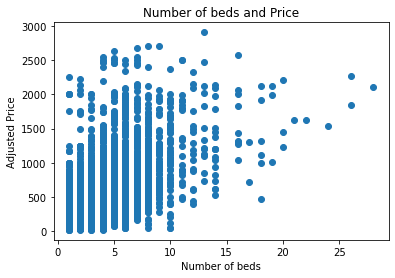

In [58]:
# Investigate number of beds with price 
plt.scatter(x = clean_merged.groupby('id').mean().beds, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Number of beds and Price")
plt.xlabel("Number of beds")
plt.ylabel("Adjusted Price")
plt.show()

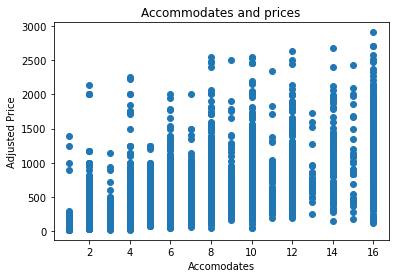

In [59]:
# Investigate Accommodates with price 
plt.scatter(x = clean_merged.groupby('id').mean().accommodates, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Accommodates and prices")
plt.xlabel("Accomodates")
plt.ylabel("Adjusted Price")
plt.show()

In [65]:
# Heatmap graph to visualize locations 
heatmap = folium.Map(location=[featured_listing['latitude'].mean(), 
                               featured_listing['longitude'].mean()], 
                                zoom_start=10)


HeatMap(data=featured_listing[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().\
        reset_index().values.tolist(), radius=8, max_zoom=13).add_to(heatmap)


heatmap

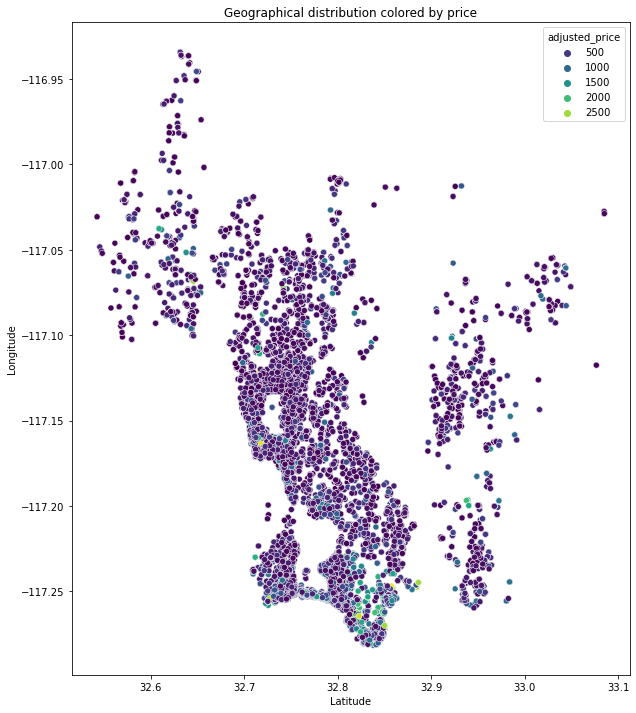

In [63]:
# Scatter plot for geolocation data colored by price
plt.figure(figsize=(10,12))
sns.scatterplot(x='latitude', y='longitude', hue='adjusted_price', palette='viridis', data=filtered_df)
plt.title('Geographical distribution colored by price')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

This scatter plot illustrates the relationship between longitude, latitude, and price. In the plot, lighter colors represent higher prices. It is evident that certain clusters, such as La Jolla and Midtown, contain a higher concentration of higher-priced listings.

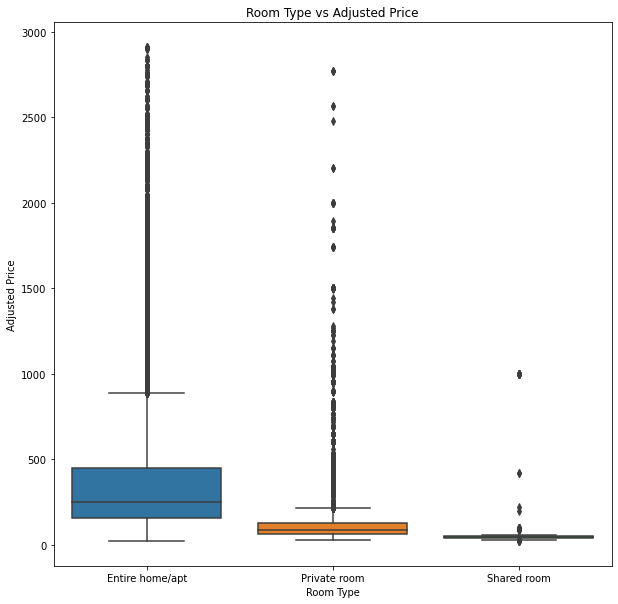

In [64]:
# Box plot for room_type and price
plt.figure(figsize=(10,10))
sns.boxplot(x='room_type', y='adjusted_price', data=filtered_df)
plt.title('Room Type vs Adjusted Price')
plt.xlabel('Room Type')
plt.ylabel('Adjusted Price')
plt.show()

### Subsection 2 Baseline Model

For the baseline model, we used a simple Linear Regression model. The rationale behind choosing this as the baseline model was its simplicity and efficiency in handling regression tasks. We want to build a model that can predict higher than chance but is also extremly simple. We did a train and test split for this model with test size is 25% of the data. We put all the columns into column transformers to one-hot encode 'neighbourhood_cleansed' and standardize both 'accommodates' and 'beds' column. The linear regression model had on $R^2$ score 0.5219 on train set and 0.5373 on test set, with a RMSE of 243.7537 on train set and 244.3095 on test set. 

In [15]:
# Base model with 'neighbourhood_cleansed', 'accommodates', 'beds' and 'day_of_week' features 

# Split testing and trainning set 
X_base = filtered_df[['neighbourhood_cleansed', 'accommodates', 'beds', 'day_of_week']]
y_base = filtered_df['adjusted_price']
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.25)

In [16]:
# Column transformer 
preproc = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['neighbourhood_cleansed']), 
        ('std', StandardScaler(), ['accommodates', 'beds'])
    ],
    remainder = 'passthrough'
)

In [17]:
# Creating the base model pipleline 
base_pl = Pipeline([('pre', preproc), ('lin-reg', LinearRegression())])
base_pl.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_cleansed']),
                                                 ('std', StandardScaler(),
                                                  ['accommodates', 'beds'])])),
                ('lin-reg', LinearRegression())])

In [35]:
print(base_pl.score(X_train, y_train), base_pl.score(X_test, y_test))

0.5218518132621365 0.5372861056202679


In [36]:
print(rmse(base_pl.predict(X_train), y_train), rmse(base_pl.predict(X_test), y_test))

243.7537183539119 244.30951193494266


### Subsection 3 Model Selection and Hyperparameter Tuning for Random Forest 

We also experimented with a RandomForestRegressor model For the RandomForestRegressor we used the same input columns as our base model since those feature seems to be the most relavent feature for predicting price. We first built a random forest regressor and put it into GridSearchCV to test the hyperparameter for 'max_depth' for each tree and 
'n_estimators'. The reason we only tried to tune those two hyerparameters are because those are the most important parameters for Random Forest. And from previous knowledge we have, if we want to have a good model, we need to focus on those features instead of others. In the end, we found that a max_depth of 32 and n_estimators of 9 gave us the best results. We obtained 0.6530 for test set $R^2$ and 0.74071 for train set $R^2$. intrestingly, even though our $R^2$ is higher than our base model, the RMSE did not decrease. The RMSE for the training is 293.3184 and for testing is 296.0445. Our conclusion for this is that random forest might not be the best choice when it comes to high demisional data since as ours. 

In [20]:
# split training and testing set for final model 
X_forest = filtered_df[['accommodates', 'room_type', 'day_of_week', 'neighbourhood_cleansed', 'beds']]
y_forest = filtered_df['adjusted_price']
X_train, X_test, y_train, y_test = train_test_split(X_forest, y_forest, test_size=0.25) 

In [21]:
# Preprocess and creating the final model pipline

# Adding ColumnTransformer to feature engineer different columns 
preproc = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['room_type', 'neighbourhood_cleansed']),
        ('standardize', StandardScaler(), ['accommodates'])
    ], 
    remainder = 'passthrough'
)

# Creating final model pipline using RandomForestRegressor
dt = Pipeline([
            ('pre', preproc), 
            ('clf', RandomForestRegressor(max_depth=1, 
                                          n_estimators=1))
        ])
       
# Fit the trainning data 
dt.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['accommodates'])])),
                ('clf', RandomForestRegressor(max_depth=1, n_estimators=1))])

In [22]:
# Perform a search for the best model and hyperparameters

# Tuning the hyperparameters
hyperparameters = {
    'clf__max_depth': np.arange(2, 60, 15), 
    'clf__n_estimators': np.arange(5, 15, 2)
}

# Applying GridSearch to pipline and fit with trainning data
grids = GridSearchCV(dt, param_grid=hyperparameters, return_train_score=True, verbose = 4)
grids.fit(X_train, y_train)

# find the best parameters 
grids.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END clf__max_depth=2, clf__n_estimators=5;, score=(train=0.427, test=0.446) total time=   0.1s
[CV 2/5] END clf__max_depth=2, clf__n_estimators=5;, score=(train=0.434, test=0.444) total time=   0.1s
[CV 3/5] END clf__max_depth=2, clf__n_estimators=5;, score=(train=0.441, test=0.433) total time=   0.1s
[CV 4/5] END clf__max_depth=2, clf__n_estimators=5;, score=(train=0.448, test=0.413) total time=   0.1s
[CV 5/5] END clf__max_depth=2, clf__n_estimators=5;, score=(train=0.433, test=0.431) total time=   0.1s
[CV 1/5] END clf__max_depth=2, clf__n_estimators=7;, score=(train=0.431, test=0.448) total time=   0.1s
[CV 2/5] END clf__max_depth=2, clf__n_estimators=7;, score=(train=0.430, test=0.441) total time=   0.1s
[CV 3/5] END clf__max_depth=2, clf__n_estimators=7;, score=(train=0.442, test=0.441) total time=   0.1s
[CV 4/5] END clf__max_depth=2, clf__n_estimators=7;, score=(train=0.446, test=0.411) total time=   0.1s
[C

{'clf__max_depth': 47, 'clf__n_estimators': 13}

first results {'clf__max_depth': 47, 'clf__n_estimators': 11}

In [23]:
train_score = grids.score(X_train, y_train)
test_score = grids.score(X_test, y_test)
train_rmse = rmse(dt.predict(X_train), y_train)
test_rmse = rmse(dt.predict(X_test), y_test)
print(train_score, test_score, train_rmse, test_rmse)

0.7407113592632311 0.6530029361644349 293.3184932419684 296.0445734191644


### Subsection 4 Model Selection and Hyperparameter Tuning for Multilayer Perceptron

Since we also want to investigate and try the model approach or machine learning, we utilized the Multilayer Perceptron neural network to help us predict the daily price of  airbnb. We built a 3 layer MLP model with input size equal to 107 and Relu as the activation function. For the hidden layers, it goes through a linear layer with 1028. The network is wide because since the network is not extremely complicated, we want to build a wider network to still correctly capture the complexity of the data. Similar to the other models, we use RMSE to calculate the loss.
In order to let the computer train the model most efficiently, we utilized the GPU and put the number of workers to 3 when loading the data. By doing so, if we want to increase our data size, we will still be able to train the model within a short period of time. 


For tuning hyperparameters, we have a batch size of 128. We also tuned the learning rate multiple times. We first started with 10 epochs to see if the learning rate is too large that the model’s loss is oscillating or if the learning rate is too small where the model will not converge. After successfully finding the suitable learning rate `lr = 5e-5`. We implemented an early stopping method to make sure the model will not overfit and helped us find the best number of epochs which is 40. We successfully obtained RMSE for training set 228.3902 and 220.1582
For validation set.

In [74]:
# Obtain df to perform Multilayer perceptron
mlp_df = filtered_mlp[['accommodates', 'room_type', 'day_of_week', 'neighbourhood_cleansed', 'beds']]
encoded_df = pd.get_dummies(mlp_df, columns=['room_type', 'neighbourhood_cleansed'])
target_df = filtered_mlp[['adjusted_price']]
encoded_df = pd.concat([encoded_df, target_df], axis = 1)

In [76]:
# Dataset
class BaseDataset(Dataset):
    def __init__(self, data, test = False):
        if test == False:
            self.inputs = data.iloc[:, :-1]
            self.labels = data.iloc[:, -1]
        else:
            self.inputs = data.iloc[:, :]
            self.labels = data.iloc[:, -1]

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index, test = False):
        input_list = self.inputs.iloc[index].tolist()
        label_list = self.labels.iloc[index].tolist()
        input_tensor = torch.tensor(input_list, dtype=torch.float32)
        label_tensor = torch.tensor(label_list, dtype=torch.float32).unsqueeze(dim=0)
        
        return input_tensor, label_tensor
    
# Helper function to split data into train and validation
def train_val_split(train_dataset, portion = 0.8):
    train_size = int(len(train_dataset) * portion)
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size], 
                                            generator=torch.Generator().manual_seed(42))
    return train_subset, val_subset

In [77]:
# Split dataset 
base_dataset = BaseDataset(encoded_df)
base_train1_subset, base_test_subset = train_val_split(base_dataset)
base_train_subset, base_val_subset = train_val_split(base_train1_subset)

In [78]:
# Set batch size, load data into dataloader 
batch_size = 128
base_trainloader = DataLoader(base_train_subset, batch_size=batch_size, shuffle=True, num_workers=3)
base_valloader = DataLoader(base_val_subset, batch_size=batch_size, num_workers=3)

base_testloader = DataLoader(base_test_subset, batch_size = 1, shuffle = False, num_workers = 3)

In [79]:
# Investigate data input dimension
for x,y in base_dataset:
    print(f'Input has {x.shape[0]} dimension')
    print(f'Output has {y.shape[0]} dimension')
    break
print(f"size of the training data: {len(base_dataset)}")

Input has 107 dimension
Output has 1 dimension
size of the training data: 100000


In [80]:
# Define function to train neural network
def train(model, optimizer, epoch = 3):
    # train the model for _ epochs
    train_loss_perStep_records = []
    val_loss_records = []
    train_loss_records = []

    for i in (range(epoch)):
        model.train()

        train_err = []
        val_err = []
        for d_train in tqdm(base_trainloader):
            X_train = d_train[0].to("cuda")
            y_train = d_train[1].to("cuda")

            y_pred = model(X_train) 
            loss = loss_fn(y_pred, y_train) # Compute MSE
            opt.zero_grad() 
            loss.backward() 
            opt.step() 

            # show RMSE on train
            model.eval()
            with torch.no_grad():
                rmse_train_err = loss_fn(torch.tensor(y_pred), torch.tensor(y_train)).item()**0.5
                train_err.append(rmse_train_err)
                train_loss_perStep_records.append(rmse_train_err)


        print(f'Epoch: {i+1} train: {sum(train_err) / len(train_err)}')
        train_loss_records.append(sum(train_err) / len(train_err))

        model.eval()

        # Validation 
        for d_val in tqdm(base_valloader):
            X_val = d_val[0].to("cuda")
            y_val = d_val[1].to("cuda")
            with torch.no_grad():
                y_val_pred = model(X_val)
                val_err.append(loss_fn(torch.tensor(y_val_pred), torch.tensor(y_val)).item()**0.5)
    

        print(f'Epoch: {i+1} validation: {sum(val_err) / len(val_err)}')
        val_loss_records.append(sum(val_err) / len(val_err))
    return model, train_loss_perStep_records, val_loss_records, train_loss_records


In [89]:
# Define Model
model = torch.nn.Sequential(
    torch.nn.Linear(107, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 1),
)
model.to("cuda")
# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-5
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [90]:
# Train the model and save val and train rmse loss
train_loss_perStep_records = []
val_loss_records = []
train_loss_records = []

model, train_loss_perStep_records, val_loss_records, train_loss_records = train(model, optimizer = opt, epoch = 40)

100%|██████████| 500/500 [00:04<00:00, 102.92it/s]


Epoch: 1 train: 392.2936717312524


100%|██████████| 125/125 [00:01<00:00, 80.13it/s] 


Epoch: 1 validation: 261.0327723654537


100%|██████████| 500/500 [00:04<00:00, 113.77it/s]


Epoch: 2 train: 263.1274127506865


100%|██████████| 125/125 [00:01<00:00, 81.24it/s] 


Epoch: 2 validation: 245.0250107758906


100%|██████████| 500/500 [00:04<00:00, 119.68it/s]


Epoch: 3 train: 252.82763828762995


100%|██████████| 125/125 [00:01<00:00, 70.43it/s] 


Epoch: 3 validation: 239.8680378974248


100%|██████████| 500/500 [00:04<00:00, 106.36it/s]


Epoch: 4 train: 249.25488482501132


100%|██████████| 125/125 [00:01<00:00, 82.14it/s] 


Epoch: 4 validation: 237.74630568670474


100%|██████████| 500/500 [00:04<00:00, 109.74it/s]


Epoch: 5 train: 246.92928382492974


100%|██████████| 125/125 [00:01<00:00, 73.54it/s] 


Epoch: 5 validation: 235.10050245754366


100%|██████████| 500/500 [00:04<00:00, 104.67it/s]


Epoch: 6 train: 244.1115063916514


100%|██████████| 125/125 [00:01<00:00, 78.25it/s] 


Epoch: 6 validation: 233.29465676754


100%|██████████| 500/500 [00:04<00:00, 115.69it/s]


Epoch: 7 train: 243.18116319522971


100%|██████████| 125/125 [00:01<00:00, 76.11it/s] 


Epoch: 7 validation: 231.9853156244409


100%|██████████| 500/500 [00:04<00:00, 115.20it/s]


Epoch: 8 train: 241.75722037704304


100%|██████████| 125/125 [00:01<00:00, 76.11it/s] 


Epoch: 8 validation: 230.61344257203405


100%|██████████| 500/500 [00:04<00:00, 111.83it/s]


Epoch: 9 train: 239.2741263698382


100%|██████████| 125/125 [00:01<00:00, 95.23it/s] 


Epoch: 9 validation: 229.27084693169655


100%|██████████| 500/500 [00:04<00:00, 105.20it/s]


Epoch: 10 train: 238.31987820156417


100%|██████████| 125/125 [00:01<00:00, 85.03it/s] 


Epoch: 10 validation: 228.67016607545057


100%|██████████| 500/500 [00:04<00:00, 113.02it/s]


Epoch: 11 train: 237.8276242313084


100%|██████████| 125/125 [00:02<00:00, 54.59it/s] 


Epoch: 11 validation: 227.6511947573625


100%|██████████| 500/500 [00:04<00:00, 104.50it/s]


Epoch: 12 train: 236.42615429689536


100%|██████████| 125/125 [00:01<00:00, 77.15it/s] 


Epoch: 12 validation: 227.40578057241393


100%|██████████| 500/500 [00:04<00:00, 115.96it/s]


Epoch: 13 train: 235.33931180306826


100%|██████████| 125/125 [00:01<00:00, 86.66it/s] 


Epoch: 13 validation: 226.35875137440118


100%|██████████| 500/500 [00:04<00:00, 121.42it/s]


Epoch: 14 train: 235.3318087835375


100%|██████████| 125/125 [00:01<00:00, 83.26it/s] 


Epoch: 14 validation: 225.74207590635882


100%|██████████| 500/500 [00:05<00:00, 96.61it/s] 


Epoch: 15 train: 234.8447258752961


100%|██████████| 125/125 [00:01<00:00, 78.29it/s] 


Epoch: 15 validation: 225.31032912072945


100%|██████████| 500/500 [00:04<00:00, 108.52it/s]


Epoch: 16 train: 233.82956439907034


100%|██████████| 125/125 [00:01<00:00, 74.32it/s] 


Epoch: 16 validation: 224.9330859935124


100%|██████████| 500/500 [00:04<00:00, 118.24it/s]


Epoch: 17 train: 232.96190300493913


100%|██████████| 125/125 [00:01<00:00, 80.67it/s] 


Epoch: 17 validation: 224.79390022744658


100%|██████████| 500/500 [00:04<00:00, 118.62it/s]


Epoch: 18 train: 232.82314230101258


100%|██████████| 125/125 [00:01<00:00, 83.28it/s] 


Epoch: 18 validation: 223.82989369551913


100%|██████████| 500/500 [00:04<00:00, 114.96it/s]


Epoch: 19 train: 232.70173054818787


100%|██████████| 125/125 [00:01<00:00, 81.93it/s] 


Epoch: 19 validation: 223.54952976037407


100%|██████████| 500/500 [00:04<00:00, 105.47it/s]


Epoch: 20 train: 232.26413528476016


100%|██████████| 125/125 [00:01<00:00, 78.96it/s] 


Epoch: 20 validation: 224.40929775314473


100%|██████████| 500/500 [00:04<00:00, 110.46it/s]


Epoch: 21 train: 232.18900013875086


100%|██████████| 125/125 [00:01<00:00, 79.47it/s] 


Epoch: 21 validation: 222.85579325678663


100%|██████████| 500/500 [00:04<00:00, 114.43it/s]


Epoch: 22 train: 231.7226112333959


100%|██████████| 125/125 [00:01<00:00, 80.04it/s] 


Epoch: 22 validation: 223.146976740307


100%|██████████| 500/500 [00:04<00:00, 115.85it/s]


Epoch: 23 train: 231.18908053266634


100%|██████████| 125/125 [00:01<00:00, 72.44it/s] 


Epoch: 23 validation: 222.30752584443422


100%|██████████| 500/500 [00:04<00:00, 112.39it/s]


Epoch: 24 train: 230.95551124199366


100%|██████████| 125/125 [00:01<00:00, 81.61it/s] 


Epoch: 24 validation: 222.59596086667534


100%|██████████| 500/500 [00:04<00:00, 110.43it/s]


Epoch: 25 train: 230.6376638103446


100%|██████████| 125/125 [00:01<00:00, 85.30it/s] 


Epoch: 25 validation: 222.36259501437985


100%|██████████| 500/500 [00:04<00:00, 100.24it/s]


Epoch: 26 train: 230.72309770369412


100%|██████████| 125/125 [00:01<00:00, 85.76it/s] 


Epoch: 26 validation: 221.98849408030736


100%|██████████| 500/500 [00:04<00:00, 121.29it/s]


Epoch: 27 train: 230.62170546527364


100%|██████████| 125/125 [00:01<00:00, 79.52it/s] 


Epoch: 27 validation: 221.64734113788944


100%|██████████| 500/500 [00:04<00:00, 110.43it/s]


Epoch: 28 train: 230.33589130139117


100%|██████████| 125/125 [00:01<00:00, 75.79it/s] 


Epoch: 28 validation: 221.9513074111312


100%|██████████| 500/500 [00:04<00:00, 112.78it/s]


Epoch: 29 train: 230.21897100993402


100%|██████████| 125/125 [00:01<00:00, 81.16it/s] 


Epoch: 29 validation: 221.30870872773414


100%|██████████| 500/500 [00:04<00:00, 104.99it/s]


Epoch: 30 train: 229.890767924163


100%|██████████| 125/125 [00:01<00:00, 68.73it/s] 


Epoch: 30 validation: 221.0663554940772


100%|██████████| 500/500 [00:04<00:00, 108.96it/s]


Epoch: 31 train: 230.0356957280775


100%|██████████| 125/125 [00:01<00:00, 74.98it/s] 


Epoch: 31 validation: 221.8289435641165


100%|██████████| 500/500 [00:04<00:00, 113.65it/s]


Epoch: 32 train: 229.32825575658288


100%|██████████| 125/125 [00:01<00:00, 90.08it/s] 


Epoch: 32 validation: 221.02795759118692


100%|██████████| 500/500 [00:04<00:00, 112.23it/s]


Epoch: 33 train: 229.25606324961382


100%|██████████| 125/125 [00:01<00:00, 77.58it/s] 


Epoch: 33 validation: 220.90105355581483


100%|██████████| 500/500 [00:04<00:00, 108.37it/s]


Epoch: 34 train: 229.40128963840073


100%|██████████| 125/125 [00:01<00:00, 77.89it/s] 


Epoch: 34 validation: 220.83775789362548


100%|██████████| 500/500 [00:04<00:00, 114.00it/s]


Epoch: 35 train: 229.02614067113765


100%|██████████| 125/125 [00:01<00:00, 71.20it/s] 


Epoch: 35 validation: 220.9169074770959


100%|██████████| 500/500 [00:04<00:00, 109.52it/s]


Epoch: 36 train: 229.08373720462288


100%|██████████| 125/125 [00:01<00:00, 76.31it/s] 


Epoch: 36 validation: 220.56915953049386


100%|██████████| 500/500 [00:04<00:00, 118.27it/s]


Epoch: 37 train: 228.60818273373405


100%|██████████| 125/125 [00:01<00:00, 82.31it/s] 


Epoch: 37 validation: 220.99844619167337


100%|██████████| 500/500 [00:03<00:00, 125.32it/s]


Epoch: 38 train: 228.69420410545942


100%|██████████| 125/125 [00:01<00:00, 80.16it/s] 


Epoch: 38 validation: 220.5003917390406


100%|██████████| 500/500 [00:04<00:00, 103.67it/s]


Epoch: 39 train: 228.79815753208078


100%|██████████| 125/125 [00:01<00:00, 74.94it/s] 


Epoch: 39 validation: 220.63142513075923


100%|██████████| 500/500 [00:04<00:00, 112.95it/s]


Epoch: 40 train: 228.39024676380686


100%|██████████| 125/125 [00:01<00:00, 79.98it/s] 

Epoch: 40 validation: 220.15820781100786


In [92]:
print(train_loss_records[-1], val_loss_records[-1])

228.39024676380686 220.15820781100786


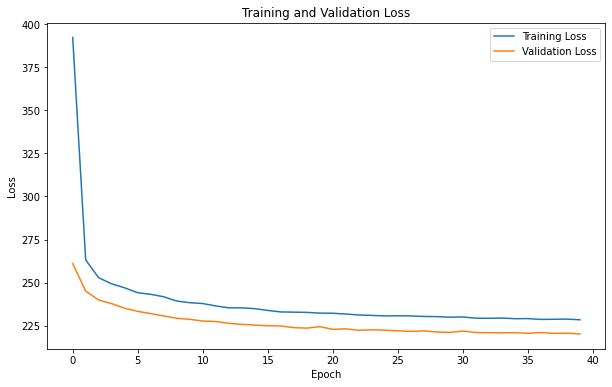

In [91]:
plt.figure(figsize=(10, 6)) 

# Plot training loss
plt.plot(train_loss_records, label='Training Loss')
# Plot validation loss
plt.plot(val_loss_records, label='Validation Loss')

# Set plot title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Subsection 5 Model Evaluation

After implementing simple linear regression, Random Forest regressor, and Multilayer Perceptron, we concluded that the best model for our task is the Multilayer Perceptron. It provides the smallest RMSE error for the testing set, with a testing loss of 220.1582. This is significantly better than the linear regression model with an RMSE of 244.3095, and the random forest regressor with an RMSE of 296.0445.

# Discussion

### Interpreting the result

#### Feature Selection 
- The robustness of our predictive model can be largely attributed to our careful feature selection. We did some exploratory data analysis on our data and selected the columns that have a positive linear relationship with price as our selected feature for our model. By focusing on impactful features such as 'accommodates', 'room_type', 'day_of_week', 'neighbourhood_cleansed', and 'beds', we were able to capture the significant influences on the pricing in our models. As for the features such as availability and amenities, we did not include them in our model training due to their relative lack of influence on price dynamics.  

#### Model Selection
- In this project, we explored both traditional machine learning methods such as Linear Regression and RandomForestRegressor, as well as a modern neural network approach using Multilayer Perceptron (MLP). After evaluating all three models, we found that the Multilayer Perceptron emerged as the superior model with exceptional performance in handling this kind of complex predictive task. In our case, we built a 3-layer NN, through a linear layer with 1028. We focus more on our width since it is considered to be more computational efficient.

#### Model Evaluation
- The model’s excellent performance showcases the potential of machine learning models in predicting real-world prices with significant precision. With a training duration of 40 epochs, the validation loss could be reduced to as low as 220.1582. The learning curve demonstrates that the model starts to converge after approximately 2-3 epochs, suggesting a high learning efficiency. Compared to the traditional models we used, MLP performs tremendously better under the evaluation metrics we chose. Linear Regression model also suggests a potential usage in solving our problem with a decent performance. Even though Linear Regression is simple technically, it performs decently well with RMSE of 243.7537 on training and 244.3095 on testing. The model with the worst performance is Random Forests. Although it has a better R^2 score than Linear Regression, the RMSE of RF is significantly higher than the two models we have gone through. So we suggest that Random Forest is not a suitable model for our problem.

#### Baseline Model Performance
- As for the more conventional models like Linear Regression and RandomForestRegressor, we obtained decent results. Our linear regression model exhibited similar training and testing errors at around 0.5, with comparable RMSE scores for training and testing, at 243 and 244 respectively. Despite their relatively lower performance compared to MLP, their results serve as a useful benchmark for understanding the problem's complexity and evaluating the benefits of using more advanced models like MLP.

#### Performance Metrics
- The evaluation of our models' performances played a critical role in accessing the performance of our predictive models. We relied heavily on the Root Mean Squared Error (RMSE) metric as our key evaluation metric. Our decision to use RMSE was grounded in its usefulness for quantifying the average magnitude of the error, providing an aggregated measure of the model’s accuracy. This model is particularly helpful when objectively comparing model performance on the same problem.


### Limitations

For our models, we utilized 100,000 data points for training and testing. With more data, we might be able to achieve better results. These models could have potentially benefited from additional features, including more diverse variables such as reviews or host-related data. Furthermore, due to computational constraints, we only explored a limited range of hyperparameters. Additionally, it is possible that we missed out on some competitive advantages, such as proximity to grocery stores or entertainment venues. If we had more time to run the data, we would train using RandomForestRegressor with a larger dataset to obtain more accurate results. Additionally, we could employ more sophisticated methods to reduce entropy.

### Ethics & Privacy

- Data Collection:
    - Informed consent:
Our dataset is extracted from official documentation published by Airbnb. The information can be searched online and hosts sign a form of consent when the properties are listed on the market, so there should not be any legal issues.
    - Collection bias:
The dataset is comprehensively collected from every single listing in the area of San Diego. So, there is no foreseeable bias in the process of data collection.
    - Limit PII exposure:
The dataset contains names of the hosts, so we will delete the sensitive information such as their ID and names of the hosts in the data cleaning processes.


- Data Storage
    - Data Security and Right to be forgotten
In compliance with regulations such as the GDPR, we respect the 'right to be forgotten.' If an individual whose data is included in our project requests for their data to be erased, we are obligated to do so, provided there are no legal grounds for retaining it. This helps to ensure that individuals maintain control over their personal data.
    - Data retention plan:
We recognize the importance of not retaining data longer than necessary. Our default position will be to retain data for only as long as it is required for the purpose of the project. Once the data is no longer necessary, we will safely and securely delete it.


- Analysis
    - Missing perspectives
For this project, we do not obtain the source of expertise knowledge or any affected communities. 
    - Dataset bias: 
Our datasets record the fundamental features of listings in San Diego are. The data it contained does not contain any information that can be related to stereotype perpetuation or imbalance classes. One variable that might be confounding in our dataset is “license”. According to our research, Airbnb's official forum provides information regarding this feature. Excerpting from Airbnb’s official response: “Some cities require Hosts to obtain a license or registration number to list their places on Airbnb. The corresponding field on their listing allows them to show that number for compliance.” This provides us an understanding of what a license is and how it applies to the property listing. Additionally, Airbnb also suggests that “license” might not be necessary for some cities, depending on the policies. For those properties that have status ‘city registration pending’ or ‘exempt’, Airbnb claims that it will not affect the veracity and safety of the listings.
    - Honest Representation:
Our visualizations, summary statistics, and reports will honestly represent the underlying data.
    - Privacy in Analysis:
Yes, we will remove the data that are related to IDs or host name in the data cleaning process.
    - Auditability:
Yes, the process will be able to reproduce using the dataset we provides and the technique we used. 



- Modeling
    - Proxy Discrimination:
We will ensure that the model does not inadvertently result in discrimination through the use of proxy variables - variables that correlate with protected characteristics such as race, age, or gender.
    - Fairness across groups:
We will prioritize fairness across all groups to ensure that no one group will receive favor based on any characteristics. We will utilize techniques to check if our model is biased, and if it is, we will mitigate it and re-evaluate our model.
    - Metric selection:
RMSE
    - Explainability:
We aim to choose a model that achieves a balance between explainability and accuracy. While more complex models offer better accuracy and predictiveness, it will more often be harder to explain. It is important for us to understand how a model is making its decisions.


- Deployment
    - Monitoring and evaluation:
Once the model is deployed, there is a need to monitor the performance and fairness continuously. We will track metrics like the model’s accuracy and potential bias over time and across different groups.
Redress
    - Roll back:
A roll-back plan will be in place to revert to a previous version of the model or even to stop using the model altogether if serious issues arise. This could be necessary if the model starts performing poorly or if significant bias is discovered that can't be quickly mitigated. 
    - Redress:
We will officially apologize to those who are harmed by our project and provide contact information for them to reach out for a solution
    - Unintended use:
Some unintended use for our project can be customers/guests using our results to argue with the host for lower prices, which might have negative effects on the revenue of listing properties.


### Conclusion

Our ultimate goal is to enhance pricing transparency and fairness in the marketplace, benefiting all users of the platform. Our analysis involves the use of three machine learning models: Linear Regression, Random Forest Regressor, and Multilayer Perceptron (MLP). Our results show that MLP fits the data the best and our models are indeed capable of predicting future prices based on historical data. The MLP model demonstrated the value of incorporating complex models for such tasks, contributing to a broader range of applications in price prediction, especially with the rise of private sharing markets.

For potential future updates, we would like to frequently update the prices and make real-time predictions to stay relevant in dynamic market conditions. This would ensure that the model remains responsive to changes in the market, ensuring continued accuracy and relevance. Additionally, we might want to explore and train other neural network models, such as Convolutional Neural Networks and Recurrent Neural Networks, to evaluate their performance on this type of data and constantly update the model.

# Footnotes
<a name="airbnbstats"></a>1.[^](#airbnbstats): “Airbnb Statistics [2023]: User & Market Growth Data.” SearchLogistics, 28 Apr. 2023, www.searchlogistics.com/learn/statistics/airbnb-statistics/. <br>
<a name="airbnbsd"></a>2.[^](#airbnbsd): “San Diego.” Inside Airbnb: Home, insideairbnb.com/san-diego. Accessed 17 May 2023. 
